In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
with open(r"F:\projects\PlayGround\gsoft\data\names.txt") as f:
    words = f.read().splitlines()

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {ch:i+1 for i,ch in enumerate(chars)}
stoi['.'] = 0
itos = {i:ch for ch,i in stoi.items()}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join(itos[i] for i in l)

vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and appended
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP

n_embed = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator=g) * 0.2
b1 = torch.randn(n_hidden,                          generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0

batch_norm_gain = torch.ones((1, n_hidden))
batch_norm_bias = torch.zeros((1, n_hidden))

bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, batch_norm_gain, batch_norm_bias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [7]:
-torch.tensor(1/27.0).log() #expected starting loss

tensor(3.2958)

In [8]:
#optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #mini_batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = batch_norm_gain * (hpreact - bnmeani) / bnstdi + batch_norm_bias
    
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bnmeani
        bn_std_running = 0.999 * bn_std_running + 0.001 * bnstdi
    
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1341
  20000/ 200000: 2.3173
  30000/ 200000: 2.4115
  40000/ 200000: 2.0124
  50000/ 200000: 2.3003
  60000/ 200000: 2.4708
  70000/ 200000: 2.1208
  80000/ 200000: 2.3562
  90000/ 200000: 2.1095
 100000/ 200000: 1.9329
 110000/ 200000: 2.3919
 120000/ 200000: 1.9795
 130000/ 200000: 2.4764
 140000/ 200000: 2.3703
 150000/ 200000: 2.3098
 160000/ 200000: 2.0003
 170000/ 200000: 1.8345
 180000/ 200000: 2.0355
 190000/ 200000: 1.8853


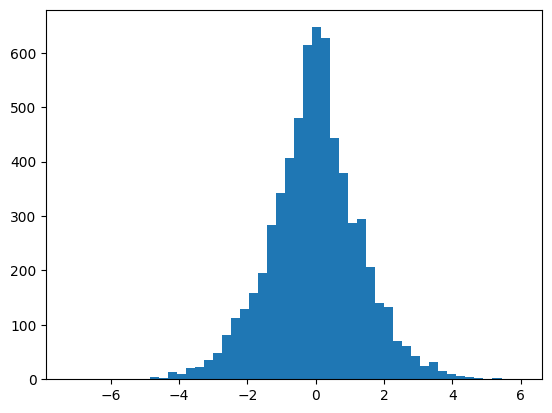

In [10]:
plt.hist(hpreact.view(-1).tolist(),50);

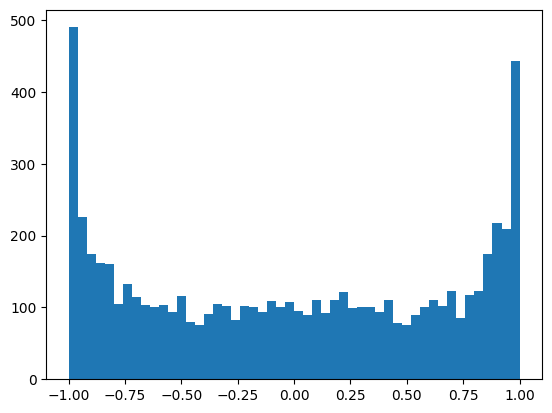

In [11]:
plt.hist(h.view(-1).tolist(),50);

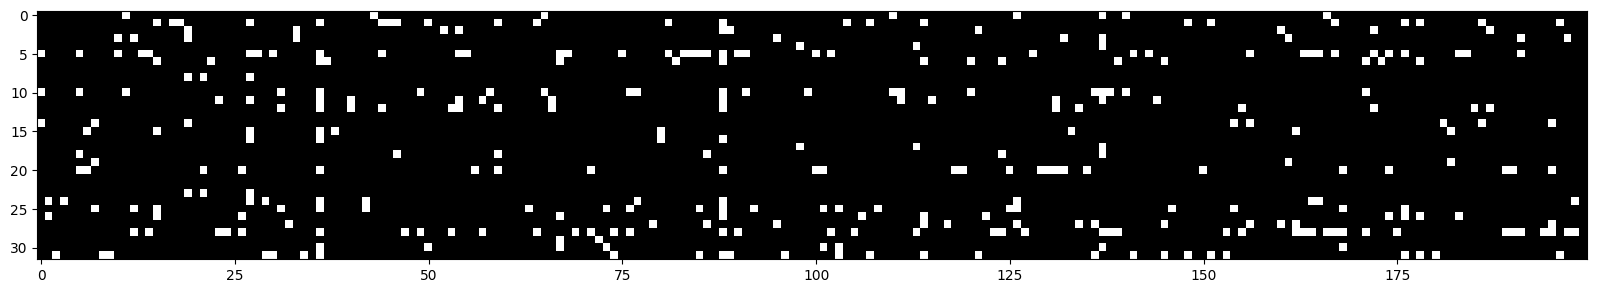

In [12]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

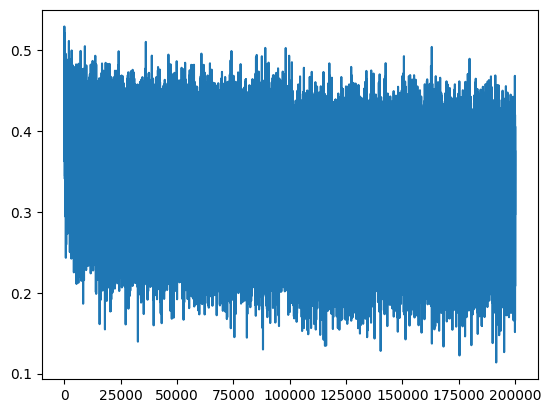

In [13]:
plt.plot(lossi)

In [14]:
# #calibrate the batch norm at the end of training

# with torch.no_grad():
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 + b1
#     bmean = hpreact.mean(0, keepdim=True)
#     bnstd = hpreact.std(0, keepdim=True)

In [15]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = batch_norm_gain * (hpreact - bn_mean_running) / bn_std_running + batch_norm_bias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')   

train 2.061837673187256
val 2.102471113204956


In [48]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print("".join(out))

mora.
mayah.
see.
mad.
ryll.
renvestendraegusteredielin.
shi.
jen.
edeiseananar.
kayzion.
kamin.
shubergianaiya.
kinde.
jennex.
teron.
ububynder.
yarue.
els.
kayshaykella.
hal.


In [6]:
#-----Summary-------- _______TORCHIFY_______________

In [52]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        self.running_mean = torch.zeros(dim) 
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar +self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn(vocab_size, n_embed)

layers = [
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

# # without the batch norm
# with torch.no_grad():
#     layers[-1].weight *= 0.1
#     for layer in layers[:-1]:
#         if isinstance(layer, Linear):
#             layer.weight *= 5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024


In [53]:
#optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    #mini_batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
      
    #backward pass
    for layer in layers:
        layer.out.retain_grad() # remove after debug
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    
    if i > 1000:
        break

      0/ 200000: 3.3129


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.06%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 2.88%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated: 2.41%
layer 11 (      Tanh): mean -0.01, std 0.64, saturated: 2.59%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 2.44%


Text(0.5, 1.0, 'activation distribution')

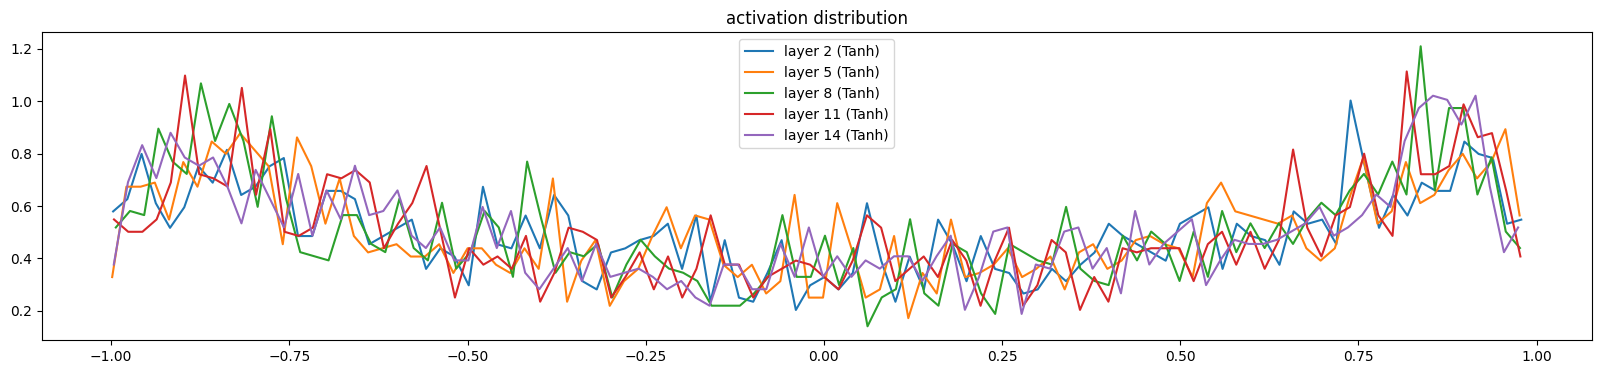

In [54]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 0.003385
layer 5 (      Tanh): mean -0.000000, std 0.002891
layer 8 (      Tanh): mean -0.000000, std 0.002934
layer 11 (      Tanh): mean +0.000000, std 0.002695
layer 14 (      Tanh): mean -0.000000, std 0.002542


Text(0.5, 1.0, 'gradient distribution')

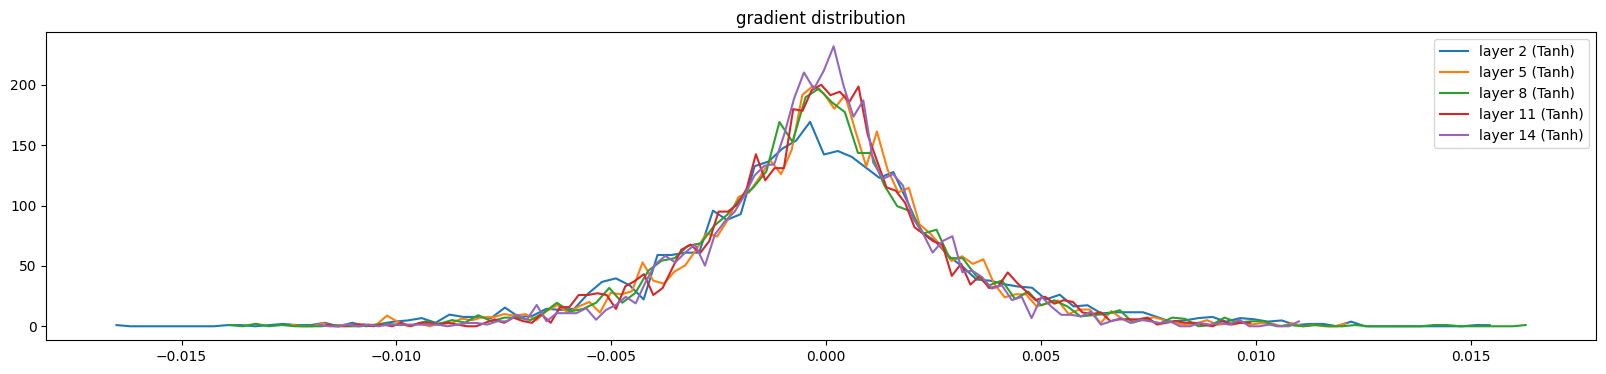

In [55]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.6f, std %.6f' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.071472e-03 | grad:data ratio 8.305755e-03
weight  (30, 100) | mean +0.000018 | std 7.124097e-03 | grad:data ratio 1.927345e-02
weight (100, 100) | mean +0.000045 | std 5.482313e-03 | grad:data ratio 2.724030e-02
weight (100, 100) | mean +0.000006 | std 4.988035e-03 | grad:data ratio 2.487474e-02
weight (100, 100) | mean +0.000021 | std 4.799724e-03 | grad:data ratio 2.390231e-02
weight (100, 100) | mean -0.000029 | std 4.806014e-03 | grad:data ratio 2.377679e-02
weight  (100, 27) | mean -0.000171 | std 8.714365e-03 | grad:data ratio 4.384755e-02


Text(0.5, 1.0, 'weight gradient distribution')

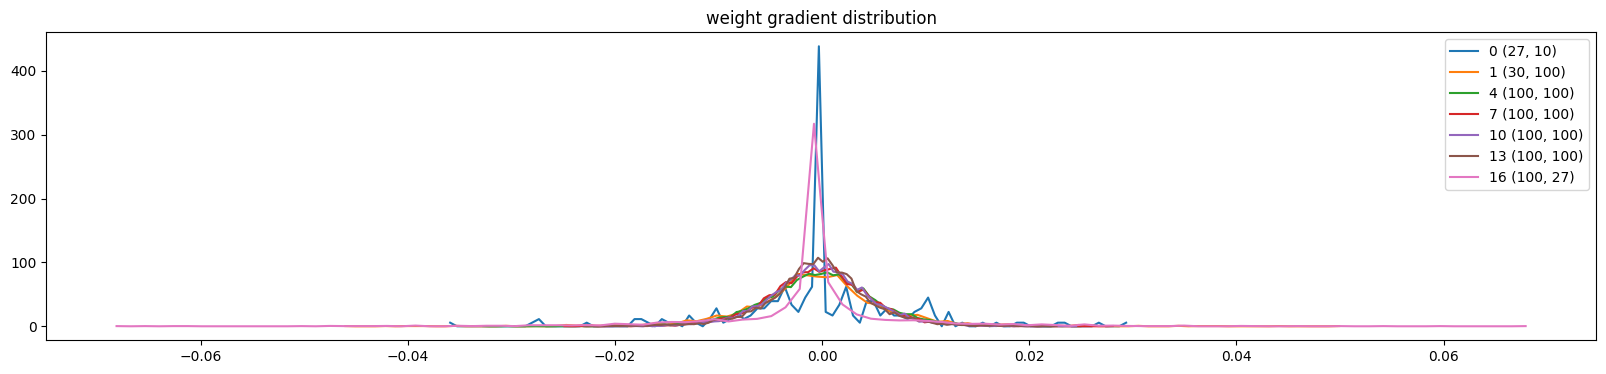

In [56]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weight gradient distribution')

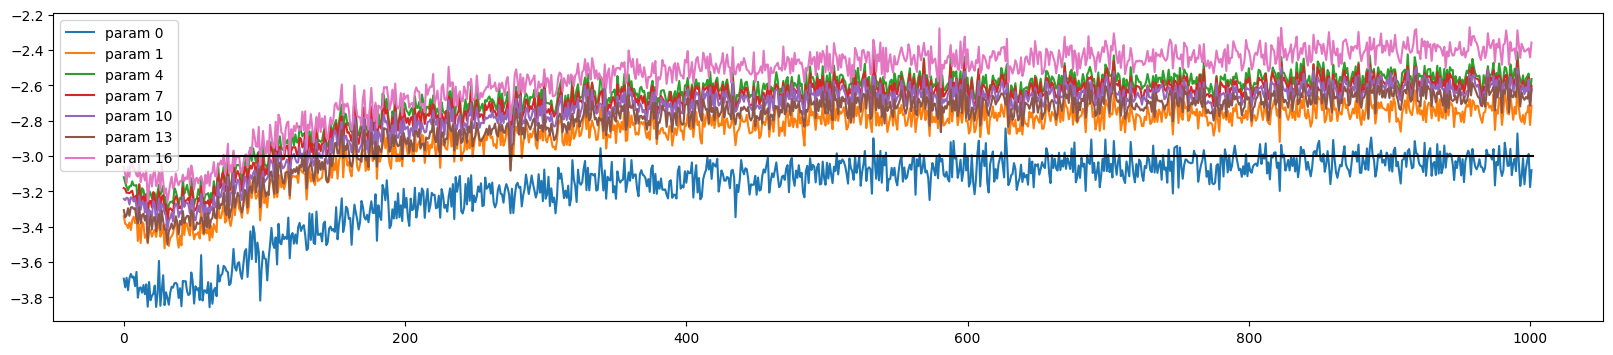

In [57]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);